In [13]:
import os
import time
import json
import utils
import parse
import fasttext
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

files = !ls backup*.txt


df = pd.concat(
    [utils.read_record(file) for file in files], 
    ignore_index=True)[["macroF1", "microF1", "y_pred", "y_true", "train", "eval"]]
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']


# Table 2: FULL vs dedup

In [49]:
first_train = "full"
first_eval = "test_full"

second_train = "dd"
second_eval = "test_dd"

def analyze(*args, first_train=None, first_eval=None, second_train=None, second_eval=None):
    first = df[(df.train == first_train) & (df["eval"] == first_eval)]
    second = df[(df.train == second_train) & (df["eval"] == second_eval)]

    fma = first.macroF1.values
    fmi = first.microF1.values

    sma = second.macroF1.values
    smi = second.microF1.values

    def get_asterisks(p_value):
        if p < 0.001:
            return "^{***}"
        elif p < 0.01:
            return "^{**}"
        elif p < 0.05:
            return "^{*}"
        else:
            return ""
    fmamark = ""
    if fma.mean() > sma.mean():
        p = stats.mannwhitneyu(fma,sma, alternative='greater')[1]
        fmamark = get_asterisks(p)
    smamark = ""
    if fma.mean() <= sma.mean():
        p = stats.mannwhitneyu(sma, fma, alternative='greater')[1]
        smamark = get_asterisks(p)

    fmimark = ""
    if fmi.mean() > smi.mean():
        p = stats.mannwhitneyu(fmi,smi, alternative='greater')[1]
        fmimark = get_asterisks(p)
    smimark = ""
    if fmi.mean() <= smi.mean():
        p = stats.mannwhitneyu(smi, fmi, alternative='greater')[1]
        smimark = get_asterisks(p)

    print(f"""
    train on {first_train}, evaluate on {first_eval} \t & {fmi.mean():0.3} \pm {fmi.std():0.2} {fmimark} \t & {fma.mean():0.3} \pm {fma.std():0.2} {fmamark}\\\\ \cline{'{1-3}'}
    train on {second_train}, evaluate on {second_eval} \t & {smi.mean():0.3} \pm {smi.std():0.2} {smimark} \t & {sma.mean():0.3} \pm {sma.std():0.2} {smamark}\\\\ \cline{'{1-3}'}
    """)
analyze(first_train="full", first_eval="test_full", second_train="dd", second_eval="test_dd")




    train on full, evaluate on test_full 	 & 0.607 \pm 0.019  	 & 0.596 \pm 0.033 ^{*}\\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016 ^{***} 	 & 0.575 \pm 0.037 \\ \cline{1-3}
    


In [50]:
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']


# XLM roberta results inclusion:

In [132]:
analyze(first_train="dd", first_eval="test_dd", second_train="xlm_dd", second_eval="test_dd")


    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 \\ \cline{1-3}
    train on xlm_dd, evaluate on test_dd 	 & 0.624 \pm 0.015  	 & 0.579 \pm 0.024 \\ \cline{1-3}
    


# Secondary labels;

In [51]:
analyze(first_train="secondary_dd", first_eval="test_dd", second_train="dd", second_eval="test_dd")


    train on secondary_dd, evaluate on test_dd 	 & 0.635 \pm 0.011  	 & 0.558 \pm 0.026 \\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 ^{*}\\ \cline{1-3}
    


# Downcasting:

In [52]:
analyze(first_train="downsampled_dd", first_eval="downsampled_test_dd", second_train="dd", second_eval="test_dd")


    train on downsampled_dd, evaluate on downsampled_test_dd 	 & 0.696 \pm 0.011 ^{***} 	 & 0.382 \pm 0.016 \\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 ^{***}\\ \cline{1-3}
    


As seen below, we first need to recalculate F1 scores:

In [61]:
df[df.train=="downsampled_dd"]

,macroF1,microF1,y_pred,y_true,train,eval
477,0.368,0.706,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
478,0.399,0.688,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
479,0.393,0.701,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
480,0.376,0.683,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
481,0.399,0.675,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
482,0.389,0.673,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
483,0.357,0.706,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
484,0.373,0.678,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
485,0.392,0.695,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
486,0.373,0.673,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd


In [63]:
def recalculate_f1_on_reduced(y_true, y_pred):
    y_true = utils.to_label(y_true, reduced=True)
    y_pred = utils.to_label(y_pred, reduced=True)
    mi = f1_score(y_true, y_pred, average="micro")
    ma = f1_score(y_true, y_pred, average="macro")

    return mi, ma
for i in df[df.train=="downsampled_dd"].index:
    y_true = df.loc[i, "y_true"]
    y_pred = df.loc[i, "y_pred"]

    mi, ma = recalculate_f1_on_reduced(y_true, y_pred)

    df.loc[i, "microF1"] = mi
    df.loc[i, "macroF1"] = ma


In [65]:
analyze(first_train="downsampled_dd", first_eval="downsampled_test_dd", second_train="dd", second_eval="test_dd")


    train on downsampled_dd, evaluate on downsampled_test_dd 	 & 0.696 \pm 0.011 ^{***} 	 & 0.668 \pm 0.028 ^{***}\\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 \\ \cline{1-3}
    


# Replotting figure 2 with new ordering:

```
list_categories_by_frequency = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']

list_of_categories_matrix = ['Information/Explanation','Research Article','Instruction','Recipe', 'Legal/Regulation','Call','Announcement','News/Reporting','Opinionated News','Opinion/Argumentation','Review','Promotion','Promotion of a Product','Promotion of Services','Invitation','Forum','Interview','Correspondence','Prose','List of Summaries/Excerpts','Other']


list_of_categories_matrix_donwnsampled = ['Information/Explanation','Instruction','Legal/Regulation','Announcement','News/Reporting','Opinionated News','Opinion/Argumentation','Promotion','Forum','Interview','List of Summaries/Excerpts','Other']

```

In [93]:
original = pd.read_csv("/home/peterr/macocu/task5_webgenres/data/interim/tabular_1d.csv")
length = original.shape[0]
percentages = dict()
for label in train_labels_no_prefix:
    percentages[label] = len(original[original.primary==label])/length
del original

to_plot = dict()
to_plot["frequency"] = percentages
df2 = df.dropna().reset_index(drop=True)

for name, setting in zip(["40%", "60%", "80%"],["minitrain_dd", "dd", "traindev_dd"]):
    c1 = df2.train == setting
    c2 = df2["eval"] == "test_dd"
    subset = df2[c1 & c2].dropna()
    y_trues = list()
    for l in subset.y_true.values:
        y_trues.extend(utils.to_label(l))
    y_preds = list()
    for l in subset.y_pred.values:
        y_preds.extend(utils.to_label(l))
    from sklearn.metrics import f1_score
    f1s = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average=None)
    current = {label: f1 for label, f1 in zip(train_labels_no_prefix, f1s)}
    current 
    #macrof1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="macro")
    #current["macroF1"] = macrof1
    #microf1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="micro")
    #current["microF1"] = microf1
    to_plot[name] = current

plotdf = pd.DataFrame(to_plot)
plotdf.sort_values(by="frequency", ascending=False)


,frequency,40%,60%,80%
Information/Explanation,0.130,0.720,0.710,0.736
News/Reporting,0.115,0.601,0.631,0.619
Promotion of a Product,0.115,0.693,0.689,0.690
Opinion/Argumentation,0.114,0.466,0.446,0.482
List of Summaries/Excerpts,0.106,0.710,0.709,0.725
Opinionated News,0.089,0.582,0.630,0.615
Forum,0.052,0.893,0.892,0.862
Other,0.042,0.306,0.282,0.286
Instruction,0.038,0.676,0.619,0.519
Invitation,0.032,0.568,0.547,0.575


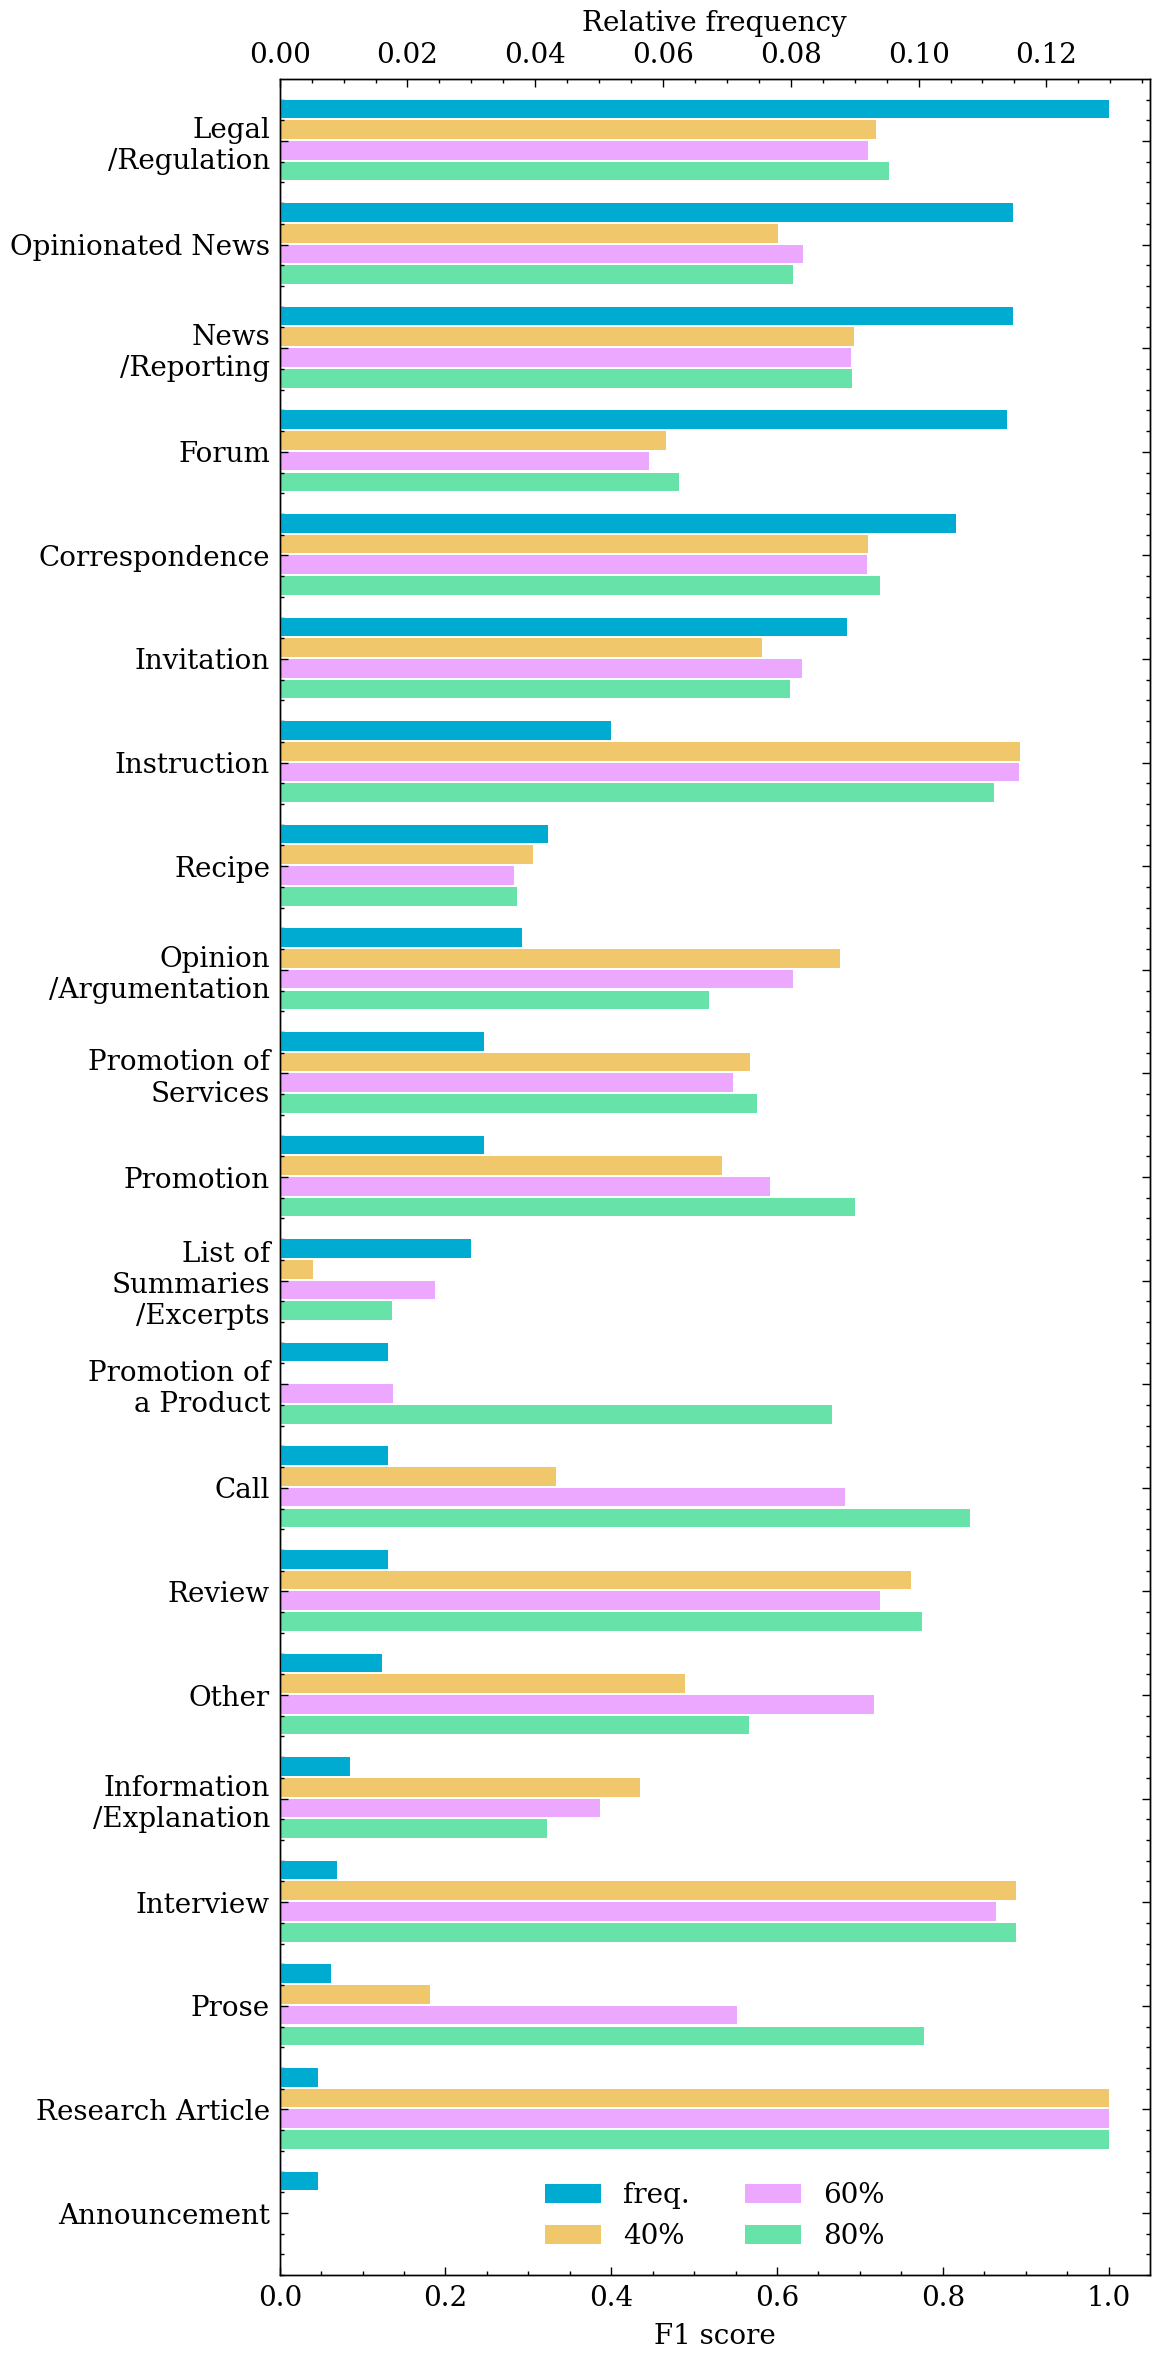

In [130]:
plotdf = pd.DataFrame(to_plot)
plotdf = plotdf.sort_values(by="frequency", ascending=False)
fig, ax = plt.subplots(figsize=(6,12), dpi=200)
ax2 = plt.twiny(ax)
spread_factor = 5
train_labels = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']
labels = train_labels_no_prefix
ind = np.arange(len(labels))*spread_factor

sep = 1
height = 0.9
lines = list()

colors = [
    "#f1c76b",
    "#eba8fe",
    "#67e3a9",
    "#00abd2"
    ]



lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

for i, col in enumerate(["40%", "60%", "80%"]):
    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, label=col, color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels([label.replace("/", "\n/").replace(" of ", " of\n") for label in labels], #fontsize="x-small"
                    )
ax.invert_yaxis()
ax.set_xlabel("F1 score")


ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, 
        # fontsize="x-small",
        ncol=2, loc=8)
ax.set_ylim(102, -4)

plt.tight_layout()
plt.savefig("paper/Q3_3.png")
plt.savefig("paper/Q3_3.pdf")
plt.show()


In [131]:
c1 = df.train == "dd"
c2 = df.

,macroF1,microF1,y_pred,y_true,train,eval
0,0.597,0.580,"[__label__Opinionated_News, __label__Opinionat...","[__label__Opinion/Argumentation, __label__Opin...",ok,test_full
1,0.688,0.685,"[__label__Opinionated_News, __label__Opinionat...","[__label__Opinion/Argumentation, __label__Opin...",ok,test_dd
2,0.566,0.585,"[__label__Opinionated_News, __label__Opinionat...","[__label__Opinion/Argumentation, __label__Opin...",ok,test_full
3,0.664,0.675,"[__label__Opinionated_News, __label__Opinionat...","[__label__Opinion/Argumentation, __label__Opin...",ok,test_dd
4,0.494,0.555,"[__label__Opinionated_News, __label__Opinionat...","[__label__Opinion/Argumentation, __label__Opin...",ok,test_full
...,...,...,...,...,...,...
512,0.462,0.588,"[2, 2, 2, 2, 2, 2, 16, 16, 16, 6, 6, 6, 8, 8, ...","[2, 2, 2, 1, 1, 1, 16, 16, 16, 6, 6, 6, 8, 8, ...",xlm_dd,dev_dd
513,0.541,0.604,"[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...",xlm_dd,devtest_dd
514,0.626,0.640,"[12, 12, 12, 16, 16, 16, 1, 1, 1, 9, 9, 9, 12,...","[12, 12, 12, 16, 16, 16, 8, 8, 8, 9, 9, 9, 12,...",xlm_dd,test_dd
515,0.580,0.643,"[2, 2, 2, 2, 2, 2, 16, 16, 16, 6, 6, 6, 8, 8, ...","[2, 2, 2, 1, 1, 1, 16, 16, 16, 6, 6, 6, 8, 8, ...",xlm_dd,dev_dd
